# 1. IMPORT

In [1]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from pytorchtools import EarlyStopping

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


# 하이퍼파라미터 설정

In [7]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.000005
        self.batch_size=16
        self.shuffle = True
        self.seed=600
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/healthcare/healthcare5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [ ]:
from sklearn.utils import shuffle
trainset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

In [ ]:
# loss확인 실험

In [14]:
df1 = pd.concat([trainset,testset,valset],axis=0)
# df1.to_excel('final_all_healthdata.xlsx',index=False)

In [104]:
df1

,clean_text,cos_dis,수도라벨
515,주파수 및 가속도를 독립적 또는 연동으로 조설 가능한 소닉 제너래이터 중제어 핵심 ...,0.842924,5
822,원격 바이오 레이더 센서 상용 시스템 및 공간융합센서를 활용한 확장형 개인건강관리 ...,0.831936,5
1560,차년도 단계에서는 단계 차년도에서 완성된 의 보청기 시스템을 임상평가하고 이에 따른...,0.828643,5
656,제 세부에서는 개인특화 의료지원 데이터웨어하우스화 기술 및 지식 자기 조직화 기술을...,0.827690,5
895,융합형 초음파 아날로그 디지털 신호처리기 설계를 목표로 초음파 시스템의 범용 회로 ...,0.825808,9
...,...,...,...
1823,임플란트 시술시 자가 골 이식을 돕기 위한 기능을 포함한,0.276925,5
2454,유방암 진단을 위한 세포조직학적 방법을 대체 할 수 있는,0.273220,7
301,의 용도에 따른 의 개발,0.267426,9
1502,저압을 이용한 챔버 형태의 하지부정맥 치료기의 개발,0.265826,5


In [117]:
(0.84+0.19)/2

0.515

In [122]:
half_head_df=df1[df1['cos_dis']>0.52]
half_tail_df=df1[df1['cos_dis']<0.52]
print(len(half_head_df))
print(len(half_tail_df))

half_head_df=half_head_df.sample(1357)
print(len(half_head_df))
print(len(half_tail_df))


3560
1357
1357
1357


In [121]:
half_head_df.tail()

,clean_text,cos_dis,수도라벨
1638,차세대 펜슬빔 양성자치료법의 치료 선량 측정 시스템을 개발\n 체렌코프선 이용한 펜...,0.603748,9
1834,센터 역활\n 선진 기준에 적합한 임상시험용 의약품 생산 및 품질시스템 구축 및 제...,0.620234,7
1037,심혈관 영상기술은 보건의료산업의 대표적 고부가가치 영역인 의료영상분야에서도 첨단 기...,0.727658,9
208,류마티스 관절염 신약 개발이 생물학적 치료제 중심으로 이루어지고 있으며 낮은 순응도...,0.646885,8
117,발굴된 폐암 바이오마커들의 검증 분석 및 통계처리\n 대규모 임상검증의 완료\n 검...,0.616810,7


In [120]:
half_tail_df.tail()

,clean_text,cos_dis,수도라벨
1823,임플란트 시술시 자가 골 이식을 돕기 위한 기능을 포함한,0.276925,5
2454,유방암 진단을 위한 세포조직학적 방법을 대체 할 수 있는,0.273220,7
301,의 용도에 따른 의 개발,0.267426,9
1502,저압을 이용한 챔버 형태의 하지부정맥 치료기의 개발,0.265826,5
574,완도 주민의 정신건강과 삶의 질 정도를 알아본다,0.187571,8


In [107]:
head_df=df1[df1['cos_dis']>0.624473]
head_df= head_df.sample(196)

median_df=df1[(df1['cos_dis']> 0.406022)&(df1['cos_dis']<0.624473)]
median_df=median_df.sample(196)

tail_df=df1[df1['cos_dis']< 0.406022]

In [108]:
print(len(head_df))
print(len(median_df))
print(len(tail_df))

196
196
196


In [123]:
head_df.tail()

,clean_text,cos_dis,수도라벨
1047,본 연구과제는 소동물에서 기능적 자기공명 추적영상기술과 정량분석법 기술을 개발하여 ...,0.649021,9
8,확산강조영상은 생체 조직 내 물 분자의 움직임을 비침습적으로 분석할 수 있는 영상 ...,0.654601,8
879,이온채널 수용체의 길항제 개발을 통한 염증질환 타겟 신약 후보물질 발굴 리드화합물 ...,0.652044,7
2475,골절환자의 치료적 목적으로 뼈에 직접적으로 견인을 함으로써 손상된 골절의 복위를 가...,0.638143,5
549,선천골수기능부전증후군 골수형성이상증후군 아밀로이드증의 원인 유전자 변이 발굴 및 검...,0.630066,6


In [126]:
median_df.tail()

,clean_text,cos_dis,수도라벨
1865,자궁경부상피이형증 면역치료제 개발을 위해 자궁경부상피이형증 환자 대상 안전성 및 치...,0.488831,8
1781,생체 세포내 가장 많은 가 양이온으로 여러 세포기능에 중요한 역할을 하고 있따 특히...,0.478841,6
2403,만성적인 과량의 알코올 섭취에 의하여 발병하는 알코올성 간질환은 명확한 발병 기전 ...,0.551743,6
2715,본 과제는 보안과제로 연구목표 내용을 입력할 수 없습니다,0.451532,5
44,현재 대부분 수입에 의존하고 있는 과색소침착증 예방 및 치료를 목적으로 하는 신규 ...,0.524604,7


In [125]:
tail_df.tail()

,clean_text,cos_dis,수도라벨
1823,임플란트 시술시 자가 골 이식을 돕기 위한 기능을 포함한,0.276925,5
2454,유방암 진단을 위한 세포조직학적 방법을 대체 할 수 있는,0.273220,7
301,의 용도에 따른 의 개발,0.267426,9
1502,저압을 이용한 챔버 형태의 하지부정맥 치료기의 개발,0.265826,5
574,완도 주민의 정신건강과 삶의 질 정도를 알아본다,0.187571,8


In [109]:
print(len(head_df))
print(len(median_df))
print(len(tail_df))

196
196
196


In [110]:
4917/3

1639.0

In [111]:
len_head_df = df1[:1639]
len_median_df = df1[1640:3279]
len_tail_df = df1[3280:]

In [128]:
len_head_df.tail()

,clean_text,cos_dis,수도라벨
205,스마트 시계 프로토타입 개발\n 인터넷 서비스 포털 구축,0.621221,5
1695,양산단계의 시제품 개발 양산 공정 개발 전임상 및 의료기기 인증 획득\n 양산단계의...,0.621177,9
1014,복강경 수술 기구에 있어서 엔드 툴이 여러 방향으로 회전할 수 있도록 다관절 구조를...,0.621152,9
2225,가 소형 분자 유전 진단 기기 및 감염성 질환 클라미디아균검사 키트 개발\n\n나 ...,0.621131,9
0,해상도복원기반 고해상도 재구성기법 개발\n영역 분할 감쇠지도 완성과 임상 평가를 통...,0.620944,9


In [129]:

len_median_df.tail()

,clean_text,cos_dis,수도라벨
384,자외선차단제로서 허가 인증과 상품화 및 자외선차단제의 광안정화 효과 시너지 효과 및...,0.536205,7
886,본 연구는 의 활성 조절을 타깃으로 한 비펩타이드성 억제제 개발을 목표로 한다 기질...,0.536160,7
2614,췌장베타세포의 인슐린분비 장애는 당뇨병의 중요한 병태생리임 베타세포의 아연수송체인 ...,0.536040,8
1905,말라리아 기생충 집단에서 말라리아 치료약에 대한 내성이 진화하는 과정에 있어서 개체...,0.536021,7
778,골다공증 또는 골절의 위험이 있는 한국 폐경여성을 예측하고 골흡수 억제제제 치료에 ...,0.535940,8


In [130]:

len_tail_df.tail()

,clean_text,cos_dis,수도라벨
1823,임플란트 시술시 자가 골 이식을 돕기 위한 기능을 포함한,0.276925,5
2454,유방암 진단을 위한 세포조직학적 방법을 대체 할 수 있는,0.273220,7
301,의 용도에 따른 의 개발,0.267426,9
1502,저압을 이용한 챔버 형태의 하지부정맥 치료기의 개발,0.265826,5
574,완도 주민의 정신건강과 삶의 질 정도를 알아본다,0.187571,8


In [114]:
half_head_df_data = CustomDataset(data=list([str(i) for i in half_head_df['clean_text'].values.copy()].copy()),
                           labels= list(half_head_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

half_head_df_loader = DataLoader(half_head_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)

half_tail_df_data = CustomDataset(data=list([str(i) for i in half_tail_df['clean_text'].values.copy()].copy()),
                           labels= list(half_tail_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

half_tail_df_loader = DataLoader(half_tail_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)

head_df_data = CustomDataset(data=list([str(i) for i in head_df['clean_text'].values.copy()].copy()),
                           labels= list(head_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

head_df_loader = DataLoader(head_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


median_df_data = CustomDataset(data=list([str(i) for i in median_df['clean_text'].values.copy()].copy()),
                           labels= list(median_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

median_df_loader = DataLoader(median_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)

tail_df_data = CustomDataset(data=list([str(i) for i in tail_df['clean_text'].values.copy()].copy()),
                           labels= list(tail_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

tail_df_loader = DataLoader(tail_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)

len_head_df_data = CustomDataset(data=list([str(i) for i in len_head_df['clean_text'].values.copy()].copy()),
                           labels= list(len_head_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

len_head_df_loader = DataLoader(len_head_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


len_median_df_data = CustomDataset(data=list([str(i) for i in len_median_df['clean_text'].values.copy()].copy()),
                           labels= list(len_median_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

len_median_df_loader = DataLoader(len_median_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)

len_tail_df_data = CustomDataset(data=list([str(i) for i in len_tail_df['clean_text'].values.copy()].copy()),
                           labels= list(len_tail_df['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

len_tail_df_loader = DataLoader(len_tail_df_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)

In [115]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)


print('half_head :',infer(model=model,loader=half_head_df_loader))
print('half_tail :',infer(model=model,loader=half_tail_df_loader))

print('head :',infer(model=model,loader=head_df_loader))
print('median :',infer(model=model,loader=median_df_loader))
print('tail :',infer(model=model,loader=tail_df_loader))

print('len_head :',infer(model=model,loader=len_head_df_loader))
print('len_median :',infer(model=model,loader=len_median_df_loader))
print('len_tail :',infer(model=model,loader=len_tail_df_loader))



85it [00:10,  7.93it/s]


test_84_stepLoss:6.225254457137164
test_84_stepacc:0.0
half_head : (6.225254457137164, 0.0)


85it [00:10,  8.00it/s]


test_84_stepLoss:5.9613289496477915
test_84_stepacc:0.0
half_tail : (5.9613289496477915, 0.0)


13it [00:01,  8.35it/s]


test_12_stepLoss:6.328651758340689
test_12_stepacc:0.0
head : (6.328651758340689, 0.0)


13it [00:01,  8.40it/s]


test_12_stepLoss:6.08212713094858
test_12_stepacc:0.0
median : (6.08212713094858, 0.0)


13it [00:01,  8.49it/s]


test_12_stepLoss:5.868907708388108
test_12_stepacc:0.0
tail : (5.868907708388108, 0.0)


103it [00:13,  7.89it/s]


test_102_stepLoss:6.359982907193379
test_102_stepacc:0.0
len_head : (6.359982907193379, 0.0)


103it [00:13,  7.90it/s]


test_102_stepLoss:6.134177087580116
test_102_stepacc:0.0
len_median : (6.134177087580116, 0.0)


103it [00:12,  7.94it/s]

test_102_stepLoss:5.973406439846002
test_102_stepacc:0.0
len_tail : (5.973406439846002, 0.0)


# 토크나이저와 모델 정의

In [60]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)
# model = torch.nn.DataParallel(model)
# model = get_peft_model(model, peft_config).to(device)

# model.print_trainable_parameters()
# model


<All keys matched successfully>

# 커스텀 데이터셋

In [61]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [12]:
train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                           labels= list(trainset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [63]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [14]:
def validate(epoch, model, loader):
    
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [64]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return t_avg_loss, t_avg_acc
    
        

# RUN

In [16]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.000005)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.* (len(train_loader) * cfg.epochs),
    num_training_steps=(len(train_loader) * cfg.epochs),
)

In [17]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)


for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, train_loader)

    lr_scheduler.step()

    validate(epoch, model, val_loader)

    # if early_stopping.early_stop:
    #     break
    
    torch.save(model, f'/home/work/CL/final_healthmodel/shuffle_{epoch+1}epoch.pt')
    
    
    # index = index + 1
df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_healthmodel/shuffle.xlsx', index=False)    

    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 5.79521369934082
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 1.6336534023284912
1_32_step_정확도 :0.25
Epoch : 1, train_64_step_loss : 1.140662670135498
1_64_step_정확도 :0.625
Epoch : 1, train_96_step_loss : 1.0227423906326294
1_96_step_정확도 :0.5625
Epoch : 1, train_128_step_loss : 0.8331541419029236
1_128_step_정확도 :0.625
Epoch : 1, train_160_step_loss : 1.0334349870681763
1_160_step_정확도 :0.5625
Epoch:1, train_184_stepLoss:1.3353642750430752
Epoch:1, train_184_stepacc:0.525
Epoch:1, train_184_stepacc:0.525
Epoch : 1, val_0_step_loss : 0.6215218901634216
1_0_step_정확도 :0.8125
Epoch : 1, val_32_step_loss : 1.142535924911499
1_32_step_정확도 :0.5
Epoch:1, val_61_stepLoss:0.8931349698574312
Epoch:1, val_61_stepacc:0.6586981566820277
Epoch:1, val_61_stepacc:0.6586981566820277
Validation loss decreased (inf --> 0.893135).  Saving model ...


 10%|█         | 1/10 [01:28<13:20, 88.91s/it]

Epoch : 2, train_0_step_loss : 0.4057232141494751
2_0_step_정확도 :0.9375
Epoch : 2, train_32_step_loss : 0.8695260882377625
2_32_step_정확도 :0.6875
Epoch : 2, train_64_step_loss : 0.5910740494728088
2_64_step_정확도 :0.875
Epoch : 2, train_96_step_loss : 1.411769151687622
2_96_step_정확도 :0.4375
Epoch : 2, train_128_step_loss : 0.47805869579315186
2_128_step_정확도 :0.875
Epoch : 2, train_160_step_loss : 0.6605532169342041
2_160_step_정확도 :0.75
Epoch:2, train_184_stepLoss:0.7665808345820453
Epoch:2, train_184_stepacc:0.7263513513513513
Epoch:2, train_184_stepacc:0.7263513513513513
Epoch : 2, val_0_step_loss : 0.4928888976573944
2_0_step_정확도 :0.8125
Epoch : 2, val_32_step_loss : 1.3221220970153809
2_32_step_정확도 :0.5625
Epoch:2, val_61_stepLoss:0.8624755644029186
Epoch:2, val_61_stepacc:0.690668202764977
Epoch:2, val_61_stepacc:0.690668202764977
Validation loss decreased (0.893135 --> 0.862476).  Saving model ...


 20%|██        | 2/10 [02:58<11:55, 89.39s/it]

Epoch : 3, train_0_step_loss : 0.8248904943466187
3_0_step_정확도 :0.6875
Epoch : 3, train_32_step_loss : 0.8542018532752991
3_32_step_정확도 :0.5625
Epoch : 3, train_64_step_loss : 0.71419757604599
3_64_step_정확도 :0.75
Epoch : 3, train_96_step_loss : 0.25640833377838135
3_96_step_정확도 :0.9375
Epoch : 3, train_128_step_loss : 0.6850477457046509
3_128_step_정확도 :0.6875
Epoch : 3, train_160_step_loss : 0.8357322812080383
3_160_step_정확도 :0.8125
Epoch:3, train_184_stepLoss:0.5785332557317373
Epoch:3, train_184_stepacc:0.7990990990990992
Epoch:3, train_184_stepacc:0.7990990990990992
Epoch : 3, val_0_step_loss : 0.49216753244400024
3_0_step_정확도 :0.875
Epoch : 3, val_32_step_loss : 1.145925760269165
3_32_step_정확도 :0.625
Epoch:3, val_61_stepLoss:0.8315557200581797
Epoch:3, val_61_stepacc:0.7232142857142857
Epoch:3, val_61_stepacc:0.7232142857142857
Validation loss decreased (0.862476 --> 0.831556).  Saving model ...


 30%|███       | 3/10 [04:28<10:26, 89.53s/it]

Epoch : 4, train_0_step_loss : 0.24252420663833618
4_0_step_정확도 :0.9375
Epoch : 4, train_32_step_loss : 0.7423000335693359
4_32_step_정확도 :0.8125
Epoch : 4, train_64_step_loss : 0.6947985887527466
4_64_step_정확도 :0.8125
Epoch : 4, train_96_step_loss : 0.10334768891334534
4_96_step_정확도 :1.0
Epoch : 4, train_128_step_loss : 0.7471470832824707
4_128_step_정확도 :0.8125
Epoch : 4, train_160_step_loss : 0.25737255811691284
4_160_step_정확도 :0.9375
Epoch:4, train_184_stepLoss:0.4227571848679233
Epoch:4, train_184_stepacc:0.8653153153153154
Epoch:4, train_184_stepacc:0.8653153153153154
Epoch : 4, val_0_step_loss : 0.4439795911312103
4_0_step_정확도 :0.875
Epoch : 4, val_32_step_loss : 1.4547860622406006
4_32_step_정확도 :0.5625
Epoch:4, val_61_stepLoss:0.9150114124340396
Epoch:4, val_61_stepacc:0.7158698156682027
Epoch:4, val_61_stepacc:0.7158698156682027
EarlyStopping counter: 1 out of 3


 40%|████      | 4/10 [05:55<08:50, 88.46s/it]

Epoch : 5, train_0_step_loss : 0.41034936904907227
5_0_step_정확도 :0.875
Epoch : 5, train_32_step_loss : 0.32990559935569763
5_32_step_정확도 :0.9375
Epoch : 5, train_64_step_loss : 0.6991872787475586
5_64_step_정확도 :0.75
Epoch : 5, train_96_step_loss : 0.18248461186885834
5_96_step_정확도 :0.9375
Epoch : 5, train_128_step_loss : 0.3495582342147827
5_128_step_정확도 :0.875
Epoch : 5, train_160_step_loss : 0.22926214337348938
5_160_step_정확도 :0.875
Epoch:5, train_184_stepLoss:0.30896975325571524
Epoch:5, train_184_stepacc:0.9047297297297298
Epoch:5, train_184_stepacc:0.9047297297297298
Epoch : 5, val_0_step_loss : 0.6817420125007629
5_0_step_정확도 :0.8125
Epoch : 5, val_32_step_loss : 1.6092549562454224
5_32_step_정확도 :0.625
Epoch:5, val_61_stepLoss:1.0633018506510603
Epoch:5, val_61_stepacc:0.7088133640552995
Epoch:5, val_61_stepacc:0.7088133640552995
EarlyStopping counter: 2 out of 3


 50%|█████     | 5/10 [07:23<07:22, 88.59s/it]

Epoch : 6, train_0_step_loss : 0.43077683448791504
6_0_step_정확도 :0.9375
Epoch : 6, train_32_step_loss : 0.3846164345741272
6_32_step_정확도 :0.875
Epoch : 6, train_64_step_loss : 0.1293255239725113
6_64_step_정확도 :0.9375
Epoch : 6, train_96_step_loss : 0.5202475190162659
6_96_step_정확도 :0.875
Epoch : 6, train_128_step_loss : 0.15657109022140503
6_128_step_정확도 :0.9375
Epoch : 6, train_160_step_loss : 0.3416067659854889
6_160_step_정확도 :0.875
Epoch:6, train_184_stepLoss:0.21838798416224686
Epoch:6, train_184_stepacc:0.9422297297297297
Epoch:6, train_184_stepacc:0.9422297297297297
Epoch : 6, val_0_step_loss : 0.8091546893119812
6_0_step_정확도 :0.75
Epoch : 6, val_32_step_loss : 1.426068902015686
6_32_step_정확도 :0.5625
Epoch:6, val_61_stepLoss:1.033585452084099
Epoch:6, val_61_stepacc:0.7078052995391705
Epoch:6, val_61_stepacc:0.7078052995391705
EarlyStopping counter: 3 out of 3


 60%|██████    | 6/10 [08:50<05:52, 88.05s/it]

Epoch : 7, train_0_step_loss : 0.2943074703216553
7_0_step_정확도 :0.9375
Epoch : 7, train_32_step_loss : 0.3602670133113861
7_32_step_정확도 :0.9375
Epoch : 7, train_64_step_loss : 0.12220638245344162
7_64_step_정확도 :0.9375
Epoch : 7, train_96_step_loss : 0.1307567059993744
7_96_step_정확도 :0.9375
Epoch : 7, train_128_step_loss : 0.19488218426704407
7_128_step_정확도 :0.9375
Epoch : 7, train_160_step_loss : 0.07780775427818298
7_160_step_정확도 :0.9375
Epoch:7, train_184_stepLoss:0.168480695814297
Epoch:7, train_184_stepacc:0.9554054054054054
Epoch:7, train_184_stepacc:0.9554054054054054
Epoch : 7, val_0_step_loss : 0.8293514251708984
7_0_step_정확도 :0.8125
Epoch : 7, val_32_step_loss : 1.6009966135025024
7_32_step_정확도 :0.625
Epoch:7, val_61_stepLoss:1.0919629417119487
Epoch:7, val_61_stepacc:0.7276785714285715
Epoch:7, val_61_stepacc:0.7276785714285715
EarlyStopping counter: 4 out of 3


 70%|███████   | 7/10 [10:17<04:22, 87.63s/it]

Epoch : 8, train_0_step_loss : 0.06959397345781326
8_0_step_정확도 :1.0
Epoch : 8, train_32_step_loss : 0.10705870389938354
8_32_step_정확도 :0.9375
Epoch : 8, train_64_step_loss : 0.12603524327278137
8_64_step_정확도 :1.0
Epoch : 8, train_96_step_loss : 0.5102198719978333
8_96_step_정확도 :0.8125
Epoch : 8, train_128_step_loss : 0.0474562793970108
8_128_step_정확도 :1.0
Epoch : 8, train_160_step_loss : 0.3127566874027252
8_160_step_정확도 :0.9375
Epoch:8, train_184_stepLoss:0.13280679365569675
Epoch:8, train_184_stepacc:0.9641891891891892
Epoch:8, train_184_stepacc:0.9641891891891892
Epoch : 8, val_0_step_loss : 0.8003411293029785
8_0_step_정확도 :0.8125
Epoch : 8, val_32_step_loss : 1.4866173267364502
8_32_step_정확도 :0.5625
Epoch:8, val_61_stepLoss:1.2487973695801151
Epoch:8, val_61_stepacc:0.721918202764977
Epoch:8, val_61_stepacc:0.721918202764977
EarlyStopping counter: 5 out of 3


 80%|████████  | 8/10 [11:44<02:54, 87.46s/it]

Epoch : 9, train_0_step_loss : 0.09594529867172241
9_0_step_정확도 :0.9375
Epoch : 9, train_32_step_loss : 0.06392714381217957
9_32_step_정확도 :1.0
Epoch : 9, train_64_step_loss : 0.11993914842605591
9_64_step_정확도 :0.9375
Epoch : 9, train_96_step_loss : 0.23932184278964996
9_96_step_정확도 :0.9375
Epoch : 9, train_128_step_loss : 0.04951819032430649
9_128_step_정확도 :1.0
Epoch : 9, train_160_step_loss : 0.018353629857301712
9_160_step_정확도 :1.0
Epoch:9, train_184_stepLoss:0.10473027249949204
Epoch:9, train_184_stepacc:0.9712837837837838
Epoch:9, train_184_stepacc:0.9712837837837838
Epoch : 9, val_0_step_loss : 0.7613373398780823
9_0_step_정확도 :0.875
Epoch : 9, val_32_step_loss : 2.0832860469818115
9_32_step_정확도 :0.5625
Epoch:9, val_61_stepLoss:1.1985410707852533
Epoch:9, val_61_stepacc:0.7319988479262672
Epoch:9, val_61_stepacc:0.7319988479262672
EarlyStopping counter: 6 out of 3


 90%|█████████ | 9/10 [13:11<01:27, 87.26s/it]

Epoch : 10, train_0_step_loss : 0.023083172738552094
10_0_step_정확도 :1.0
Epoch : 10, train_32_step_loss : 0.01377736497670412
10_32_step_정확도 :1.0
Epoch : 10, train_64_step_loss : 0.022064462304115295
10_64_step_정확도 :1.0
Epoch : 10, train_96_step_loss : 0.016064297407865524
10_96_step_정확도 :1.0
Epoch : 10, train_128_step_loss : 0.01963553950190544
10_128_step_정확도 :1.0
Epoch : 10, train_160_step_loss : 0.01295827329158783
10_160_step_정확도 :1.0
Epoch:10, train_184_stepLoss:0.06948717753528744
Epoch:10, train_184_stepacc:0.9831081081081081
Epoch:10, train_184_stepacc:0.9831081081081081
Epoch : 10, val_0_step_loss : 0.6534675359725952
10_0_step_정확도 :0.875
Epoch : 10, val_32_step_loss : 1.211094617843628
10_32_step_정확도 :0.625
Epoch:10, val_61_stepLoss:1.2662665420962917
Epoch:10, val_61_stepacc:0.7269585253456221
Epoch:10, val_61_stepacc:0.7269585253456221
EarlyStopping counter: 7 out of 3


100%|██████████| 10/10 [14:38<00:00, 87.88s/it]


In [18]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,1.335364,0.893135,0.525000,0.658698
1,2,0.766581,0.862476,0.726351,0.690668
2,3,0.578533,0.831556,0.799099,0.723214
3,4,0.422757,0.915011,0.865315,0.715870
4,5,0.308970,1.063302,0.904730,0.708813
5,6,0.218388,1.033585,0.942230,0.707805
6,7,0.168481,1.091963,0.955405,0.727679
7,8,0.132807,1.248797,0.964189,0.721918
8,9,0.104730,1.198541,0.971284,0.731999
9,10,0.069487,1.266267,0.983108,0.726959


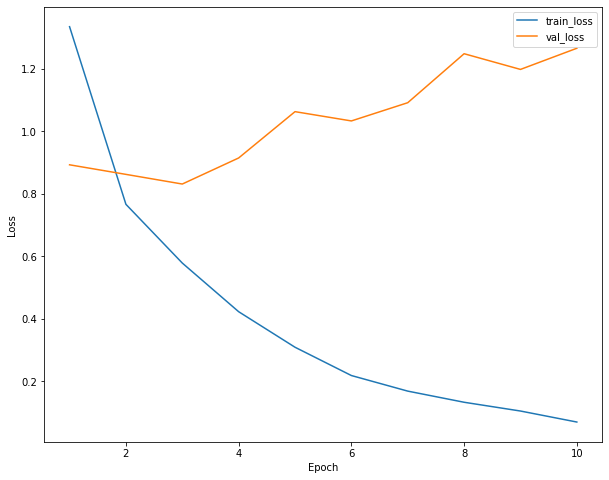

In [19]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df1['epoch'],df1['train_loss'],label='train_loss')
plt.plot(df1['epoch'],df1['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

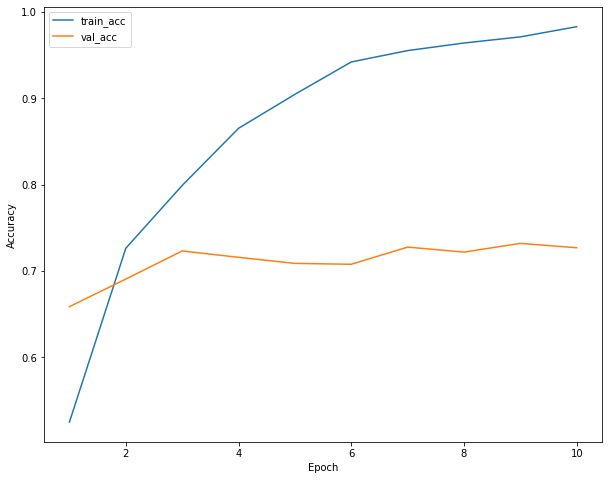

In [20]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(df1['epoch'],df1['train_acc'],label='train_acc')
plt.plot(df1['epoch'],df1['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

## 2번 도메인까지 학습한뒤 평가(정렬된거기준)

In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

for i in range(20) :
    save_path = f"/home/work/CL/final_healthmodel/shuffle_{i+1}epoch.pt"
    model = torch.load(save_path)

    print(i+1,infer(model=model,loader=test_loader))



62it [00:07,  7.85it/s]


test_61_stepLoss:0.857115789286552
test_61_stepacc:0.6784274193548387
1 (0.857115789286552, 0.6784274193548387)


62it [00:07,  7.85it/s]


test_61_stepLoss:0.7883053844974887
test_61_stepacc:0.7086693548387096
2 (0.7883053844974887, 0.7086693548387096)


62it [00:07,  7.84it/s]


test_61_stepLoss:0.7648554477960833
test_61_stepacc:0.7247983870967742
3 (0.7648554477960833, 0.7247983870967742)


62it [00:07,  7.83it/s]


test_61_stepLoss:0.8234303420589816
test_61_stepacc:0.7399193548387096
4 (0.8234303420589816, 0.7399193548387096)


62it [00:07,  7.83it/s]


test_61_stepLoss:1.0086720499300188
test_61_stepacc:0.7167338709677419
5 (1.0086720499300188, 0.7167338709677419)


62it [00:07,  7.86it/s]


test_61_stepLoss:1.0662584929696974
test_61_stepacc:0.6955645161290323
6 (1.0662584929696974, 0.6955645161290323)


62it [00:07,  7.83it/s]


test_61_stepLoss:1.0489477366809883
test_61_stepacc:0.7399193548387096
7 (1.0489477366809883, 0.7399193548387096)


62it [00:07,  7.84it/s]


test_61_stepLoss:1.2482278426928866
test_61_stepacc:0.7137096774193549
8 (1.2482278426928866, 0.7137096774193549)


62it [00:07,  7.82it/s]


test_61_stepLoss:1.2052313457092931
test_61_stepacc:0.7258064516129032
9 (1.2052313457092931, 0.7258064516129032)


62it [00:07,  7.83it/s]


test_61_stepLoss:1.2998835845820365
test_61_stepacc:0.7207661290322581
10 (1.2998835845820365, 0.7207661290322581)


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/CL/final_healthmodel/shuffle_11epoch.pt'